# Aggregate + plot GLM results across subjects
**[Contributors: James Antony](#contributions)**   

### Goal of this script
 1. Using output from GLM.ipynb, aggregate, plot, & significate results across subjects

### Steps of this script, in two parallel tracks
 1. Choose reg_model, first 1 for the main model w/ surprise, then 2 to follow-up with BC vs BIC surprise
 2. Plot / run stats on results
    - the violin plots produce Fig 4 in the paper
    - below that in the script are full plots of all coefficients from each ROI
 3. congregate all outputs and print to .csv files for loading manually into Table S4

In [1]:
subs=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
ROIs = ['NAcc','VTA2']
n_trunc=3 # Number of volumes to trim/truncate 
allcomp=1#plot comparisons
naccroi=0 # which is the NAcc ROI?
vta2roi=1 # which is the VTA ROI?
hrshiftval=5 # #volumes to shift for HMM analyses
filtcutoff=140 #high pass cutoff frequency
fact4y=1 #1=use 4-factor model,0=use KP ratings
reg_model=1 #1=main model with just surprise,2=bc vs bic surprise

In [2]:
#import packages
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
import numpy as np
import numpy.matlib as npm
import pandas as pd
import nibabel as nib
from scipy import stats, signal
from sklearn import preprocessing
from sklearn import datasets, linear_model
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns 
import scipy.io
import scipy.linalg as spla

In [3]:
#load variables
from ss_utils import ss_dir, ss_bids_dir, ss_TR, ss_hrf_lag, run_names, n_runs
analysis_dir=ss_dir+'analysis/'
if fact4y:
    mat_fname=analysis_dir+'d_event_mat1' 
else:
    mat_fname=analysis_dir+'d_event_mat0' 
mat_contents = scipy.io.loadmat(mat_fname)
d_mat_hrf = mat_contents['d_mat_hrf'] #use to size data
d_fl = mat_contents['d_fl'] #1st TR for each game
print('1st / last TR for each game: %s' %d_fl)
nS=len(subs)
nR=len(ROIs)
a=sns.color_palette() #colors for seaborn plots at the bottom
tngs=9

for subnum in range(nS):
    sub='sub-%s' %(subs[subnum])
    in_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
    mat_fname=in_dir+'glm_out-%s-%s-%s-%s-%s.mat' %(n_trunc,hrshiftval,filtcutoff,fact4y,reg_model)
    mat_contents = scipy.io.loadmat(mat_fname)
    r_coef_mass_mean = mat_contents['r_coef_mass_mean'] 
    r_coef_nacc_mass = mat_contents['r_coef_nacc_mass'] 
    r_coef_vta_mass = mat_contents['r_coef_vta_mass'] 
    masked_data_avg = mat_contents['masked_data_avg'] 
    nonzero_signed_TRs=mat_contents['nonzero_signed_TRs'] 
    masked_data_nacc = mat_contents['masked_data_nacc'] 
    masked_data_vta = mat_contents['masked_data_vta'] 
    xcoords = mat_contents['xcoords'] 
    xcoordsvta = mat_contents['xcoordsvta'] 
    fwdabthr = mat_contents['fwdabthr']
    fwdsur = mat_contents['fwdsur']
    fwdent = mat_contents['fwdent']
    if subnum==0: # preset variables (just once, after loading first subject)
        fwdabthr_all=np.zeros((nS,1))
        r_means_all=np.zeros((nS,4))
        fwdsur_all=np.zeros((nS,1))
        fwdent_all=np.zeros((nS,1))
        nz_s_TRs_a=np.zeros((nS,1))
        cats_orig_mass=mat_contents['cats_orig_mass']
        nC=len(cats_orig_mass)  
        r_coef_mass_mean_all=np.zeros((nS,nR,nC))
        masked_data_nacc_all=np.zeros((nS,masked_data_nacc.shape[0],d_mat_hrf.shape[0]))
        masked_data_vta_all=np.zeros((nS,masked_data_vta.shape[0],d_mat_hrf.shape[0]))
        r_coef_nacc_all=np.zeros((nS,nC,masked_data_nacc.shape[0]))
        r_coef_nacc_p_all=np.zeros((nS,nC,masked_data_nacc.shape[0]))
        r_coef_vta_all=np.zeros((nS,nC,masked_data_vta.shape[0]))
        r_coef_vta_p_all=np.zeros((nS,nC,masked_data_vta.shape[0]))
    r_coef_mass_mean_all[subnum,:]=r_coef_mass_mean #main data with all betas
    fwdabthr_all[subnum,0]=fwdabthr # framewise displacement time points > threshold
    fwdsur_all[subnum,0]=fwdsur #is fwd correlated w/ surprise?
    fwdent_all[subnum,0]=fwdent #is fwd correlated w/ belief-consistency?
    nz_s_TRs_a[subnum,0]=nonzero_signed_TRs # number of signed TRs
    masked_data_nacc_all[subnum,:,:]=masked_data_nacc #average NAcc activity over time
    masked_data_vta_all[subnum,:,:]=masked_data_vta #average VTA activity over time
    r_coef_nacc_all[subnum,:,:] = r_coef_nacc_mass #betas for each voxel in NAcc
    r_coef_vta_all[subnum,:,:] = r_coef_vta_mass #betas for each voxel in VTA

1st / last TR for each game: [[   1  366]
 [ 367  769]
 [ 770 1203]
 [1204 1608]
 [1609 1976]
 [1977 2297]
 [2298 2635]
 [2636 3080]
 [3081 3426]]


In [4]:
#reviewer check
#is framewise displacement correlated with surprise? or belief-consistency of surprise?
r2z=np.zeros((nS))
for sub in range(nS):
    r2z[sub]=np.multiply((np.log([1+fwdsur_all[sub,0]])-np.log([1-fwdsur_all[sub,0]])),0.5)
blank=np.zeros((nS))   
t,p=stats.ttest_rel(r2z,blank,nan_policy='omit')
print('surprise, mean=%s,sem=%s,t=%s,p=%s' %(np.mean(r2z),np.divide(np.std(r2z),np.sqrt(nS)),t,p))

surprise, mean=-0.005374917833673264,sem=0.0038884433875992098,t=-1.347279965863275,p=0.1937390917619572


In [5]:
#preset zeros
sub_mat=[]
sub_mat2=[]
roi_mat=[]
regressor_mat=[]
regressor_mat2=[]
beta_mat=[]
j=0
jj=0
nC=len(cats_orig_mass)  
blank=np.zeros((nS))   
Acc_All=np.zeros((nS,1))
VTA_All=np.zeros((nS,1))
Acc_Pref=np.zeros((nS,1))
VTA_Pref=np.zeros((nS,1))
Acc_BIC=np.zeros((nS,1))
VTA_BIC=np.zeros((nS,1))
Acc_AllUS=np.zeros((nS,1))
VTA_AllUS=np.zeros((nS,1))
Acc_PrefUS=np.zeros((nS,1))
VTA_PrefUS=np.zeros((nS,1))
ps_all=np.zeros((nC,nR))
ts_all=np.zeros((nC,nR))
ps_p=np.zeros((nC,nR))
surcol=8 #which column is surprise?
for cat in range(nC):
    add=cat 
    for roi in range(nR):
        addroi=roi 
        for sub in range(nS):
            addbeta_mass=[r_coef_mass_mean_all[sub,roi,cat]]
            if j==0:
                sub_mat=sub#add
                regressor_mat=add
                beta_mat_all=addbeta_mass
                roi_mat=addroi
                j=1
            else:
                regressor_mat=np.vstack([regressor_mat,add])
                beta_mat_all=np.vstack([beta_mat_all,addbeta_mass])
                sub_mat=np.vstack([sub_mat,sub])#add
                roi_mat=np.vstack([roi_mat,addroi])
            if cat==surcol: #surprise for reg_model=1,bc sur for reg_model=2
                if roi==naccroi:
                    Acc_All[sub]=addbeta_mass
                elif roi==vta2roi:
                    VTA_All[sub]=addbeta_mass
            elif cat==surcol+1: #signed surprise
                if roi==naccroi:
                    Acc_Pref[sub]=addbeta_mass
                elif roi==vta2roi:
                    VTA_Pref[sub]=addbeta_mass
            elif cat==surcol+2: #surprise, unscaled #was +3
                if roi==naccroi:
                    Acc_AllUS[sub]=addbeta_mass
                elif roi==vta2roi:
                    VTA_AllUS[sub]=addbeta_mass
            elif cat==surcol+3: #signed surprise, unscaled #was +4
                if roi==naccroi:
                    Acc_PrefUS[sub]=addbeta_mass
                elif roi==vta2roi:
                    VTA_PrefUS[sub]=addbeta_mass
            if reg_model==2:
                if cat==surcol+4: #bic sur
                    if roi==naccroi:
                        Acc_BIC[sub]=addbeta_mass
                    elif roi==vta2roi:
                        VTA_BIC[sub]=addbeta_mass
            
        jj=jj+1

        t,p=stats.ttest_rel(r_coef_mass_mean_all[:,roi,cat],blank,nan_policy='omit')   
        ts_all[cat,roi]=t
        ps_all[cat,roi]=p

first=0
for cat in range(10):
    add=cat 
    for sub in range(nS):
        adds=sub     
        if first==0:
            sub_mat2=adds
            regressor_mat2=add
            first=1
        else: 
            sub_mat2=np.vstack([sub_mat2,adds])
            regressor_mat2=np.vstack([regressor_mat2,add])

In [6]:
# put into data frame for plotting
df_all = pd.DataFrame(np.hstack([sub_mat,roi_mat,regressor_mat,beta_mat_all]),columns=['Subject','ROI','Regressor','beta'])
accmat=np.vstack([Acc_All,Acc_Pref])
df_acc=pd.DataFrame(np.hstack([sub_mat2[:nS*2],regressor_mat2[:nS*2],accmat]),columns=['Subject','Regressor','beta'])
accmat=np.vstack([accmat,Acc_AllUS])
accmat=np.vstack([accmat,Acc_PrefUS])
df_acc_full=pd.DataFrame(np.hstack([sub_mat2[:nS*4],regressor_mat2[:nS*4],accmat]),columns=['Subject','Regressor','beta'])
if reg_model==2:
    accmat=np.vstack([accmat,Acc_BIC])
    df_acc_full=pd.DataFrame(np.hstack([sub_mat2[:nS*5],regressor_mat2[:nS*5],accmat]),columns=['Subject','Regressor','beta'])
vtamat=np.vstack([VTA_All,VTA_Pref])
df_vta=pd.DataFrame(np.hstack([sub_mat2[:nS*2],regressor_mat2[:nS*2],vtamat]),columns=['Subject','Regressor','beta'])
vtamat=np.vstack([vtamat,VTA_AllUS])
vtamat=np.vstack([vtamat,VTA_PrefUS])
df_vta_full=pd.DataFrame(np.hstack([sub_mat2[:nS*4],regressor_mat2[:nS*4],vtamat]),columns=['Subject','Regressor','beta'])
if reg_model==2:
    vtamat=np.vstack([vtamat,VTA_BIC])
    df_vta_full=pd.DataFrame(np.hstack([sub_mat2[:nS*5],regressor_mat2[:nS*5],vtamat]),columns=['Subject','Regressor','beta'])

In [7]:
#defaults / functions for plotting
xcats_us_s=['''Unsigned 
surprise''','''Signed
surprise''']
yrange=0.6
pltrange=6 # plot size
xcats3=['''Surprise''','''Signed
surprise''']
xcats_full=['''Surprise''','''Signed
surprise''','''Surprise, scaled''','''Signed surprise, scaled''']
if reg_model==2:
    xcats_full=['''Belief-consistent urprise''','''Signed
    surprise''','''Surprise, scaled''','''Signed surprise, scaled''','''Belief-inconsistent surprise''']

def calcsig(All,Pref): #BC
    t,p=stats.ttest_rel(All[:,0],blank,nan_policy='omit')   
    print('All, p = %s' %p)
    tt,pp=stats.ttest_rel(Pref[:,0],blank,nan_policy='omit')   
    print('Pref, p = %s' %pp)
    return p,pp
def calcsigBCBIC(BC,BIC): #BC
    t,p=stats.ttest_rel(BC[:,0],blank,nan_policy='omit')   
    print('BC, p = %s' %p)
    tt,pp=stats.ttest_rel(BIC[:,0],blank,nan_policy='omit')   
    print('BIC, p = %s' %pp)
    ttt,ppp=stats.ttest_rel(BC[:,0],BIC[:,0],nan_policy='omit')   
    print('Diff, p = %s' %ppp)
    return p,pp,ppp
def plotdf(df,xcats,col,yrange,an):
    a=sns.color_palette()
    if len(xcats)==2:
        f, ax = plt.subplots(1,1, figsize=(pltrange*2/3,pltrange*3/5),tight_layout=True)
    elif len(xcats)==3:
        f, ax = plt.subplots(1,1, figsize=(pltrange*2/3,pltrange*3/5),tight_layout=True)        
    else:
        f, ax = plt.subplots(1,1, figsize=(pltrange*2,pltrange*3/5),tight_layout=True)
    ax = sns.violinplot(x="Regressor", y="beta",data=df,dodge=True,
                        inner="quartiles",color=col,linewidth=1)
    ax = sns.swarmplot(x="Regressor", y="beta",data=df,color="0",dodge=True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-yrange,yrange)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(linewidth=1, color='k')
    fign=ss_dir+'pics/%sPreference-%s.svg' %(an,hrshiftval)
    f.savefig(fign)
    x = np.arange(0,len(xcats))
    plt.xticks(x,xcats)
    ax.set_ylabel('''Beta for surprise in %s''' %an)
def plotdfcomp(df,yrange,an,xcats,pltrange,col):
    a=sns.color_palette()
    f, ax = plt.subplots(1,1, figsize=(pltrange,pltrange*2/5),tight_layout=True)
    ax = sns.violinplot(x="Regressor", y="beta",data=df,dodge=True,
                        inner="quartiles",color=col,linewidth=1)#,split=True
    ax = sns.swarmplot(x="Regressor", y="beta",data=df,color="0",dodge=True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-yrange,yrange)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(linewidth=1, color='k')
    fign=ss_dir+'pics/%sScaledComp-%s.svg' %(an,hrshiftval)
    f.savefig(fign)
    x = np.arange(0,len(xcats))
    plt.xticks(x,xcats)
    ax.set_ylabel('''Beta for surprise in %s''' %an)

All, p = 0.6086050539959273
Pref, p = 0.05592075988309436


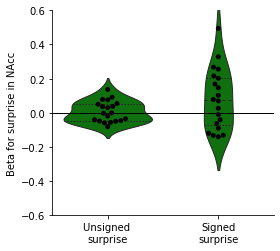

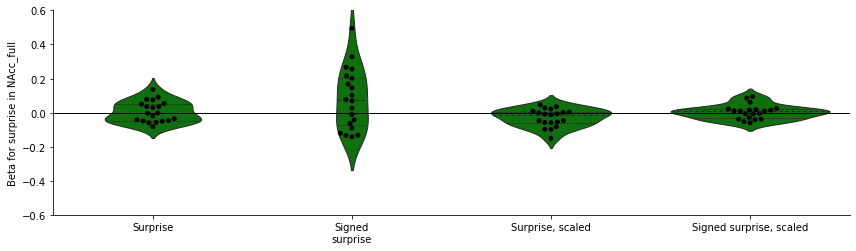

In [8]:
#accumbens
roi_p=np.zeros((2))
roi_pref_p=np.zeros((2))
roi_p[0],roi_pref_p[0]=calcsig(Acc_All,Acc_Pref)
if reg_model==2:
    roi_BC_p=np.zeros((2))
    roi_BIC_p=np.zeros((2))
    roi_BCBICdiff_p=np.zeros((2))
    roi_BC_p[0],roi_BIC_p[0],roi_BCBICdiff_p[0]=calcsigBCBIC(Acc_All,Acc_BIC)
an='NAcc'
plotdf(df_acc,xcats_us_s,"green",yrange,an)
an='NAcc_full'
plotdf(df_acc_full,xcats_full,"green",yrange,an)

All, p = 0.0023333761300937932
Pref, p = 0.00898368457223906


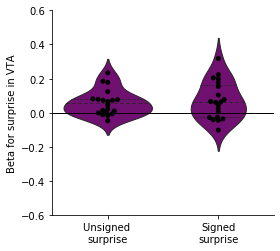

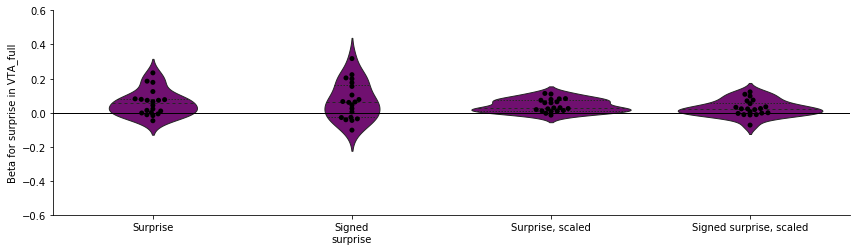

In [9]:
#VTA
roi_p[1],roi_pref_p[1]=calcsig(VTA_All,VTA_Pref)
if reg_model==2:
    roi_BC_p[1],roi_BIC_p[1],roi_BCBICdiff_p[1]=calcsigBCBIC(VTA_All,VTA_BIC)
an='VTA'
plotdf(df_vta,xcats_us_s,"purple",yrange,an)
an='VTA_full'
plotdf(df_vta_full,xcats_full,"purple",yrange,an)

vta sur p: 0.0 based on 1000 above zero
vta signed sur p: 0.0 based on 1000 above zero
nacc sur p: 0.58 based on 710 above zero
nacc signed sur p: 0.036 based on 982 above zero


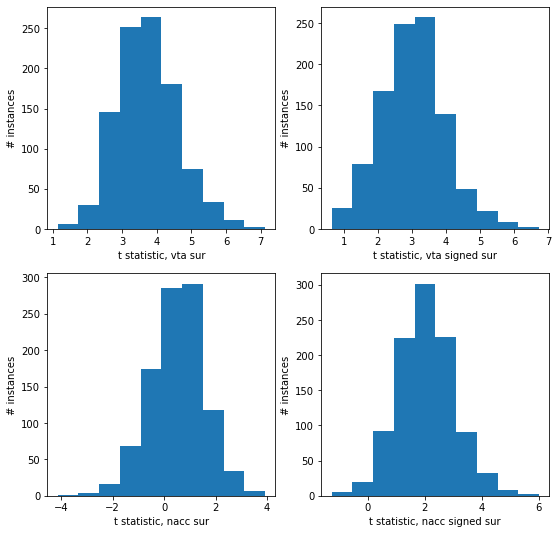

In [10]:
#bootstrapping analysis - not in use but just to check
from sklearn.utils import resample
iters=1000
temp_va=np.zeros((iters))
temp_vp=np.zeros((iters))
temp_na=np.zeros((iters))
temp_np=np.zeros((iters))
for i in range(iters):
    temp_va[i],p=stats.ttest_1samp(resample(VTA_All),0)
    temp_vp[i],p=stats.ttest_1samp(resample(VTA_Pref),0)
    temp_na[i],p=stats.ttest_1samp(resample(Acc_All),0)
    temp_np[i],p=stats.ttest_1samp(resample(Acc_Pref),0)

f,ax = plt.subplots(2,2, figsize=(9,9))
ax[0,0].hist(temp_va)
ax[0,0].set_ylabel("# instances")
ax[0,0].set_xlabel("t statistic, vta sur")
ax[0,1].hist(temp_vp)
ax[0,1].set_ylabel("# instances")
ax[0,1].set_xlabel("t statistic, vta signed sur")
ax[1,0].hist(temp_na)
ax[1,0].set_ylabel("# instances")
ax[1,0].set_xlabel("t statistic, nacc sur")
ax[1,1].hist(temp_np)
ax[1,1].set_ylabel("# instances")
ax[1,1].set_xlabel("t statistic, nacc signed sur")

prc_va=((iters-np.sum(temp_va>0))/iters)*2
print('vta sur p: %s based on %s above zero' %(prc_va,np.sum(temp_va>0)))
prc_vp=((iters-np.sum(temp_vp>0))/iters)*2
print('vta signed sur p: %s based on %s above zero' %(prc_vp,np.sum(temp_vp>0)))
prc_na=((iters-np.sum(temp_na>0))/iters)*2
print('nacc sur p: %s based on %s above zero' %(prc_na,np.sum(temp_na>0)))
prc_np=((iters-np.sum(temp_np>0))/iters)*2
print('nacc signed sur p: %s based on %s above zero' %(prc_np,np.sum(temp_np>0)))

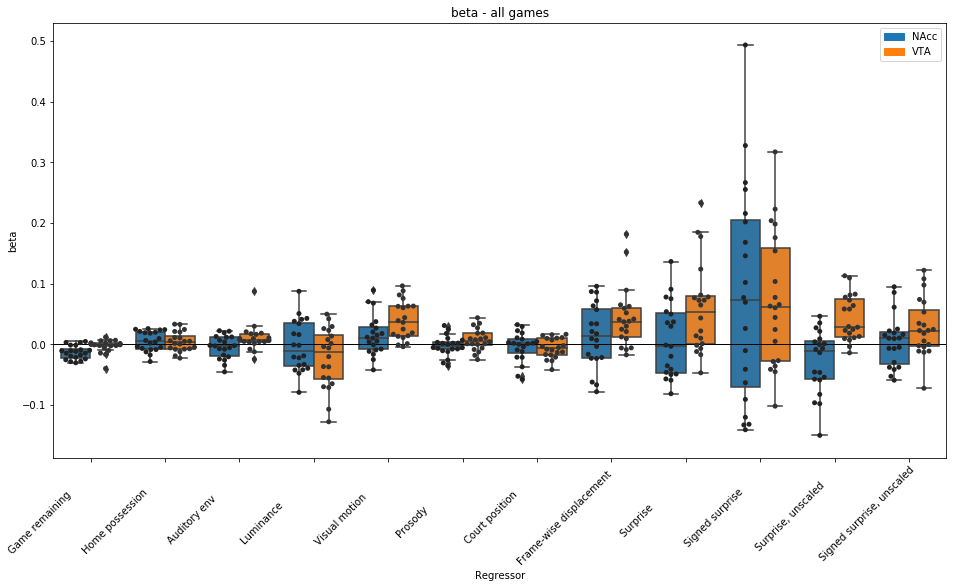

In [11]:
#plot all coefficients - visualization only, data shown as table in the paper
f, ax = plt.subplots(1,1, figsize=(16,8))
ax = sns.boxplot(x="Regressor", y="beta",hue="ROI", data=df_all,dodge=True)
ax = sns.swarmplot(x="Regressor", y="beta",hue="ROI", data=df_all,color=".2",dodge=True)
patch1 = mpatches.Patch(color=a[0], label='NAcc')
patch2 = mpatches.Patch(color=a[1], label='VTA')
plt.legend(handles=[patch1,patch2])
plt.title("beta - all games")
ax.set_xticks(np.arange(nC))
ax.set_xticklabels(cats_orig_mass)
ax.axhline(linewidth=1, color='k')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()
f.tight_layout()
fign=ss_dir+'pics/XSub_GLM_all-%s-%s.png' %(n_trunc,hrshiftval)
f.savefig(fign)

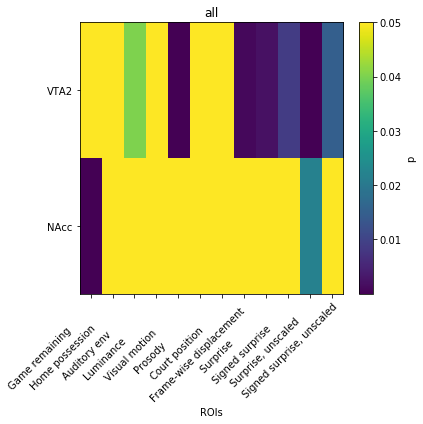

In [12]:
#plot significance for all as image map
pmax=0.05
f,ax = plt.subplots(1,1, figsize=(pltrange,pltrange))
plt.imshow(ps_all.T,cmap='viridis',origin='lower',interpolation='none',aspect="auto",vmax=pmax)
ax.set_title('all')
ax.set_xticks(np.arange(nC))
ax.set_xticklabels(cats_orig_mass)
ax.set_yticks(np.arange(nR))
ax.set_yticklabels(ROIs)
ax.set_xlabel("ROIs")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
cbar = plt.colorbar(ax=ax)
cbar.ax.set_ylabel("p")
f.tight_layout()
fign=ss_dir+'pics/XSub_GLM_Sig_all-%s-%s.png' %(n_trunc,hrshiftval)
f.savefig(fign)

In [14]:
#output .csv files for final table
t1=df_all.groupby(['Regressor','ROI']).mean()
t2=df_all.groupby(['Regressor','ROI']).std()#./sqrt(nS)['beta']
t1=t1.drop(columns=['Subject'])#df.drop(columns=['B', 'C'])
t2=t2.drop(columns=['Subject']) #standard deviation (compute SEM in Excel)
    
if reg_model==1:
    np.savetxt("GLMts.csv",np.reshape(ts_all,(ts_all.shape[0]*ts_all.shape[1])), delimiter=",")
    np.savetxt("GLMps.csv", np.reshape(ps_all,(ps_all.shape[0]*ps_all.shape[1])), delimiter=",")
    #print to CSV for table
    t1.to_csv("GLMmean.csv", index=False, encoding='utf8')
    t2.to_csv("GLMstd.csv", index=False, encoding='utf8')
elif reg_model==2:
    np.savetxt("GLMts2.csv",np.reshape(ts_all,(ts_all.shape[0]*ts_all.shape[1])), delimiter=",")
    np.savetxt("GLMps2.csv", np.reshape(ps_all,(ps_all.shape[0]*ps_all.shape[1])), delimiter=",")
    #print to CSV for table
    t1.to_csv("GLMmean2.csv", index=False, encoding='utf8')
    t2.to_csv("GLMstd2.csv", index=False, encoding='utf8')

# Test idea that there may be a lateral -> medial wave (Hamid et al., 2019, bioR) in VTA/NAcc that may be higher during games with a preference
### NOTE: not in paper

(20, 186, 3426)


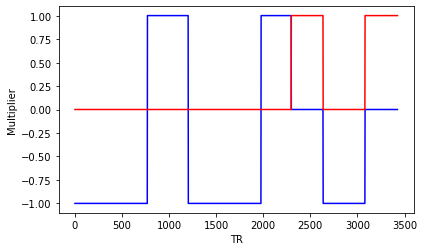

In [15]:
#grab data and re-arrange according to subject preferences
masked_data_nacc_p=np.zeros((masked_data_nacc_all.shape[0],masked_data_nacc_all.shape[1],masked_data_nacc_all.shape[2]))
masked_data_vta_p=np.zeros((masked_data_vta_all.shape[0],masked_data_vta_all.shape[1],masked_data_vta_all.shape[2]))
for subnum in range(nS):#nS
    subS = str(int(subnum+1))
    nonfmri_dir=ss_dir+'data/nonfmri/%s/' %subS
    mat_fname=nonfmri_dir+'confounds_hrf2.mat'
    mat_contents = scipy.io.loadmat(mat_fname)
    signed_hrf = mat_contents['signed_hrf'] #movie end TRs
    newmat=np.multiply(masked_data_nacc_all[subnum,:,:],signed_hrf.T)
    masked_data_nacc_p[subnum,:,:]=newmat
    newmat=np.multiply(masked_data_vta_all[subnum,:,:],signed_hrf.T)
    masked_data_vta_p[subnum,:,:]=newmat
    
f, ax = plt.subplots(1,1, figsize=(pltrange,pltrange*3/5),tight_layout=True)
ax.plot(signed_hrf,'b') #preferred games
ax.plot(np.absolute(np.absolute(signed_hrf)-1),'r') #non-preferred games
ax.set_ylabel('Multiplier')
ax.set_xlabel('TR')
print(masked_data_nacc_all.shape)

In [20]:
print('NAcc x-coordinates: %s' %xcoords)
print('VTA x-coordinates: %s' %xcoordsvta)

NAcc x-coordinates: [[7. 7. 7. 7. 7. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
  5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
  4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4.
  4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5.]]
VTA x-coordinates: [[2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 1. 1.]]


[ 0.02272683  0.01618251  0.00556214  0.01009471  0.00471246 -0.00559517
 -0.01552404]
[0.06989803 0.08317184 0.07968585 0.09512204 0.07627191 0.0559447
 0.08984472]
0.7314334466844152
[0.06228539 0.05281246 0.06585582]
[0.0814337  0.07209193 0.05830436]
0.8569055362206561


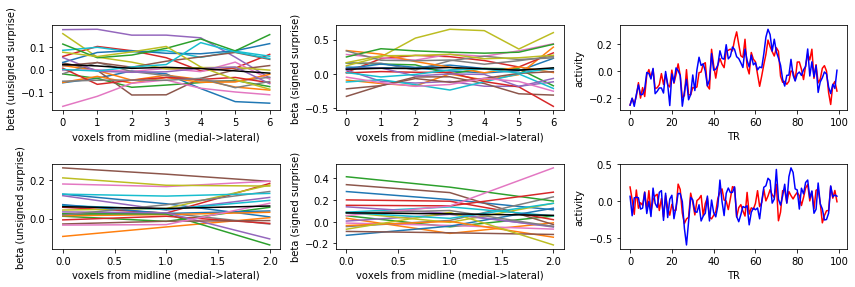

In [17]:
#bin data and ask whether beta changes across medial -> lateral and store for later x-correlations
surcat=8
psurcat=9
latnums=7
r_nacc_bin=np.zeros((nS,latnums))
r_nacc_p_bin=np.zeros((nS,latnums))
masked_data_nacc_med=np.zeros((nS,masked_data_nacc_all.shape[2]))
masked_data_nacc_lat=np.zeros((nS,masked_data_nacc_all.shape[2]))
masked_data_nacc_p_med=np.zeros((nS,masked_data_nacc_all.shape[2]))
masked_data_nacc_p_lat=np.zeros((nS,masked_data_nacc_all.shape[2]))
latnumsvta=3
r_vta_bin=np.zeros((nS,latnumsvta))
r_vta_p_bin=np.zeros((nS,latnumsvta))
masked_data_vta_med=np.zeros((nS,masked_data_vta_all.shape[2]))
masked_data_vta_lat=np.zeros((nS,masked_data_vta_all.shape[2]))
masked_data_vta_p_med=np.zeros((nS,masked_data_vta_all.shape[2]))
masked_data_vta_p_lat=np.zeros((nS,masked_data_vta_all.shape[2]))
for subnum in range(nS):
    for rbin in range(1,latnums+1):
        fill=xcoords==rbin
        fill=fill.T
        fill2=np.where(fill==1)
        r_nacc_bin[subnum,rbin-1]=np.mean(r_coef_nacc_all[subnum,surcat,fill2[0]])
        r_nacc_p_bin[subnum,rbin-1]=np.mean(r_coef_nacc_all[subnum,psurcat,fill2[0]])
    for rbin in range(latnumsvta): #starts at 0
        fill=xcoordsvta==rbin
        fill=fill.T
        fill2=np.where(fill==1)
        r_vta_bin[subnum,rbin]=np.mean(r_coef_vta_all[subnum,surcat,fill2[0]])
        r_vta_p_bin[subnum,rbin]=np.mean(r_coef_vta_all[subnum,psurcat,fill2[0]])
    for rhalf in range(2):
        if rhalf==0:
            fill=xcoords<np.mean(xcoords)
            fill=fill.T
            fill2=np.where(fill==1)
            masked_data_nacc_med[subnum,:]=np.mean(masked_data_nacc_all[subnum,fill2[0],:],axis=0)
            masked_data_nacc_p_med[subnum,:]=np.mean(masked_data_nacc_p[subnum,fill2[0],:],axis=0)
            fill=xcoordsvta<2#np.mean(xcoordsvta)
            fill=fill.T
            fill2=np.where(fill==1)
            masked_data_vta_med[subnum,:]=np.mean(masked_data_vta_all[subnum,fill2[0],:],axis=0)
            masked_data_vta_p_med[subnum,:]=np.mean(masked_data_vta_p[subnum,fill2[0],:],axis=0)
        elif rhalf==1:
            fill=xcoords>np.mean(xcoords)
            fill=fill.T
            fill2=np.where(fill==1)
            masked_data_nacc_lat[subnum,:]=np.mean(masked_data_nacc_all[subnum,fill2[0],:],axis=0)
            masked_data_nacc_p_lat[subnum,:]=np.mean(masked_data_nacc_p[subnum,fill2[0],:],axis=0)
            fill=xcoordsvta>1#np.mean(xcoordsvta)
            fill=fill.T
            fill2=np.where(fill==1)
            masked_data_vta_lat[subnum,:]=np.mean(masked_data_vta_all[subnum,fill2[0],:],axis=0)
            masked_data_vta_p_lat[subnum,:]=np.mean(masked_data_vta_p[subnum,fill2[0],:],axis=0)

pts=100
f, ax = plt.subplots(2,3, figsize=(12,4),tight_layout=True)
ax[0,0].plot(r_nacc_bin.T)
ax[0,0].plot(np.mean(r_nacc_bin.T,axis=1),'k')
ax[0,0].set_ylabel('beta (unsigned surprise)')
ax[0,0].set_xlabel('voxels from midline (medial->lateral)')
ax[0,1].plot(r_nacc_p_bin.T)
ax[0,1].plot(np.mean(r_nacc_p_bin.T,axis=1),'k')
ax[0,1].set_ylabel('beta (signed surprise)')
ax[0,1].set_xlabel('voxels from midline (medial->lateral)')
print(np.mean(r_nacc_bin.T,axis=1))
print(np.mean(r_nacc_p_bin.T,axis=1))
ax[0,2].plot(np.mean(masked_data_nacc_med[:,:pts].T,axis=1),'r')
ax[0,2].plot(np.mean(masked_data_nacc_lat[:,:pts].T,axis=1),'b')
ax[0,2].set_ylabel('activity')
ax[0,2].set_xlabel('TR')
#corr,p = stats.pearsonr(np.mean(r_nacc_p_bin.T,axis=0),np.arange(len(r_nacc_p_bin)))[0]
t,p=stats.ttest_rel(r_nacc_p_bin[:,0],r_nacc_p_bin[:,latnums-1],nan_policy='omit')   
print(p)

ax[1,0].plot(r_vta_bin.T)
ax[1,0].plot(np.mean(r_vta_bin.T,axis=1),'k')
ax[1,0].set_ylabel('beta (unsigned surprise)')
ax[1,0].set_xlabel('voxels from midline (medial->lateral)')
ax[1,1].plot(r_vta_p_bin.T)
ax[1,1].plot(np.mean(r_vta_p_bin.T,axis=1),'k')
ax[1,1].set_ylabel('beta (signed surprise)')
ax[1,1].set_xlabel('voxels from midline (medial->lateral)')
print(np.mean(r_vta_bin.T,axis=1))
print(np.mean(r_vta_p_bin.T,axis=1))
ax[1,2].plot(np.mean(masked_data_vta_med[:,:pts].T,axis=1),'r')
ax[1,2].plot(np.mean(masked_data_vta_lat[:,:pts].T,axis=1),'b')
ax[1,2].set_ylabel('activity')
ax[1,2].set_xlabel('TR')
t,p=stats.ttest_rel(r_vta_bin[:,0],r_vta_bin[:,latnumsvta-1],nan_policy='omit')   
print(p)

In [18]:
nacc_r=np.zeros((nS,1))
qq=np.arange(len(r_nacc_p_bin))
for subnum in range(nS):
    q=r_nacc_p_bin[subnum,:]#np.mean(r_nacc_p_bin.T,axis=0)
    qq=np.arange(len(q))
    #print(q)
    corr,p = stats.pearsonr(q,qq)
    nacc_r[subnum]=corr

print(np.mean(nacc_r))

0.014275291123397909


Nacc avg peak r: 0.6622606613886456
Nacc all p: 1.875791672957414e-05
Nacc pref p: 0.001925745124115726
VTA avg peak r: 0.45987931657608305
VTA all p: 0.006683301369635897
VTA pref p: 0.36627546961496027


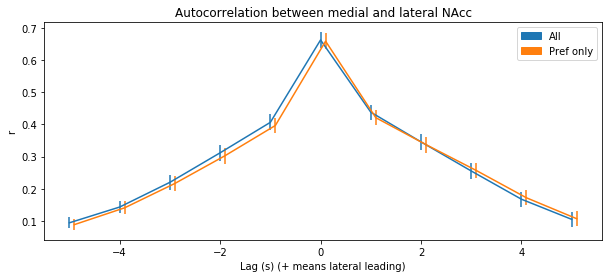

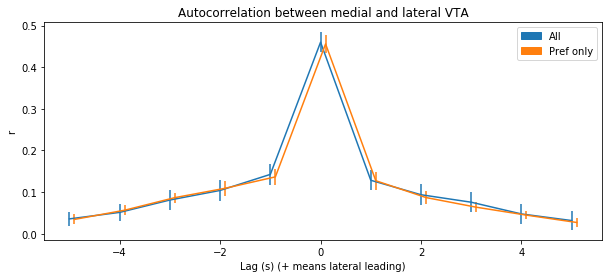

In [19]:
#perform cross-correlations and plot
def serial_corr(wave,wave2,lag=1):
    n = len(wave)
    if lag>=0:
        y1 = wave[lag:]
        y2 = wave2[:n-lag]
    elif lag<0:
        neglag=-lag
        y1 = wave[:n-neglag]
        y2 = wave2[neglag:]
    corr = np.corrcoef(y1, y2, ddof=0)[0, 1]
    return corr
def crosscorr(wave,wave2,prange):
    lags = range(-prange,prange+1)
    corrs = [serial_corr(wave,wave2, lag) for lag in lags]
    return lags, corrs

prange=5
p_lags=np.arange(-prange,prange+1) #+1
corrs_t=np.zeros((nS,p_lags.shape[0]))
corrs_p_t=np.zeros((nS,p_lags.shape[0]))
corrs_vta_t=np.zeros((nS,p_lags.shape[0]))
corrs_vta_p_t=np.zeros((nS,p_lags.shape[0]))
for subj in range(nS):
    wave=masked_data_nacc_med[subj,:]
    wave2=masked_data_nacc_lat[subj,:]
    fill,fill2=crosscorr(wave,wave2,prange)
    corrs_t[subj,:]=fill2
    wave=masked_data_nacc_p_med[subj,:]
    wave2=masked_data_nacc_p_lat[subj,:]
    fill,fill2=crosscorr(wave,wave2,prange)
    corrs_p_t[subj,:]=fill2
    wave=masked_data_vta_med[subj,:]
    wave2=masked_data_vta_lat[subj,:]
    fill,fill2=crosscorr(wave,wave2,prange)
    corrs_vta_t[subj,:]=fill2
    wave=masked_data_vta_p_med[subj,:]
    wave2=masked_data_vta_p_lat[subj,:]
    fill,fill2=crosscorr(wave,wave2,prange)
    corrs_vta_p_t[subj,:]=fill2
    
corrs=np.mean(corrs_t,axis=0)
corrs_std=np.std(corrs_t,axis=0)/np.sqrt(p_lags.shape[0])
corrs_p=np.mean(corrs_p_t,axis=0)
corrs_p_std=np.std(corrs_p_t,axis=0)/np.sqrt(p_lags.shape[0])
corrs_vta=np.mean(corrs_vta_t,axis=0)
corrs_vta_std=np.std(corrs_vta_t,axis=0)/np.sqrt(p_lags.shape[0])
corrs_vta_p=np.mean(corrs_vta_p_t,axis=0)
corrs_vta_p_std=np.std(corrs_vta_p_t,axis=0)/np.sqrt(p_lags.shape[0])

f, ax = plt.subplots(1,1, figsize = (10,4))
lils=0.1
ax.errorbar(p_lags,corrs,yerr=corrs_std,color=a[0]) #corrs[lb:ub]
ax.errorbar(p_lags+lils,corrs_p,yerr=corrs_std,color=a[1]) #corrs[lb:ub]
ax.set_title('Autocorrelation between medial and lateral NAcc')
ax.set_xlabel('Lag (s) (+ means lateral leading)')
ax.set_ylabel('r')
patch1 = mpatches.Patch(color=a[0], label='All')
patch2 = mpatches.Patch(color=a[1], label='Pref only')
plt.legend(handles=[patch1,patch2])
print('Nacc avg peak r: %s' %np.mean(corrs_t[:,prange]))
t,p=stats.ttest_rel(corrs_t[:,prange-1],corrs_t[:,prange+1],nan_policy='omit')   
print('Nacc all p: %s' %(p))
t,p=stats.ttest_rel(corrs_p_t[:,prange-1],corrs_p_t[:,prange+1],nan_policy='omit')   
print('Nacc pref p: %s' %p)

f, ax = plt.subplots(1,1, figsize = (10,4))
lils=0.1
ax.errorbar(p_lags,corrs_vta,yerr=corrs_std,color=a[0]) #corrs[lb:ub]
ax.errorbar(p_lags+lils,corrs_vta_p,yerr=corrs_vta_std,color=a[1]) #corrs[lb:ub]
ax.set_title('Autocorrelation between medial and lateral VTA')
ax.set_xlabel('Lag (s) (+ means lateral leading)')
ax.set_ylabel('r')
patch1 = mpatches.Patch(color=a[0], label='All')
patch2 = mpatches.Patch(color=a[1], label='Pref only')
plt.legend(handles=[patch1,patch2])
print('VTA avg peak r: %s' %np.mean(corrs_vta_t[:,prange]))
t,p=stats.ttest_rel(corrs_vta_t[:,prange-1],corrs_vta_t[:,prange+1],nan_policy='omit')   
print('VTA all p: %s' %p)
t,p=stats.ttest_rel(corrs_vta_p_t[:,prange-1],corrs_vta_p_t[:,prange+1],nan_policy='omit')   
print('VTA pref p: %s' %p)